In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product, count
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

import xarray as xr
import pandas as pd
import cytoolz as tz
from cytoolz import compose, merge_with, groupby
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"))

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gt: 0.005}
            },
        },
        {
            $project: {
                tag: true,
                gm2: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 14]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("gm2", DoubleType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()

Loading data...
root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)



In [4]:
combiner = load_combiner(3, [["C1p", "I1p", "I1p"]], allow_various=False)
combined = df.select("tag", "gm2", combiner("hits").alias("combined")).cache()
combined.printSchema()

root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- combined: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comb: array (nullable = false)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- t: double (nullable = false)
 |    |    |    |    |-- x: double (nullable = false)
 |    |    |    |    |-- y: double (nullable = false)
 |    |    |    |    |-- as_: map (nullable = false)
 |    |    |    |    |    |-- key: string
 |    |    |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |    |    |-- ke: double (nullable = false)
 |    |    |    |    |-- flag: integer (nullable = true)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    

In [5]:
def gen():
    pubhit = count()
    for row in combined.toLocalIterator():
        d = row.asDict(True)
        yield {"dim": "tag", "tag": d["tag"], "gm2": d["gm2"]}
        for c in d["combined"]:
            i = next(pubhit)
            yield {"dim": "hit", "tag": d["tag"], "hit": i, "flag": c["flag"]}
            for j, (h, k) in enumerate(zip(c["comb"], ["C1p", "I1p", "I1p"])):
                yield {"dim": "hit,as_", "tag": d["tag"], "hit": i, "as_": f"h{j}{k}",
                       "t": h["t"], "x": h["x"], "y": h["y"],
                       "pz": h["as_"][k]["pz"], "px": h["as_"][k]["px"], "py": h["as_"][k]["py"],
                       "ke": h["as_"][k]["ke"]}


d = tz.groupby("dim", gen())
ds = xr.merge([
    pd.DataFrame(d["tag"]).set_index("tag").drop(columns="dim").to_xarray(),
    pd.DataFrame(d["hit"]).set_index("hit").drop(columns="dim").to_xarray().rename({"tag": "tag_"}),
    pd.DataFrame(d["hit,as_"]).set_index(["hit", "as_"]).drop(columns=["dim", "tag"]).to_xarray(),
])
da = ds[["t", "x", "y", "pz", "px", "py", "ke"]].to_array("quantity")
del d
ds

<xarray.Dataset>
Dimensions:  (as_: 3, hit: 68554, tag: 585878)
Coordinates:
  * tag      (tag) int64 158648231 158648232 158648233 ... 157417386 157417387
  * hit      (hit) int64 0 1 2 3 4 5 6 ... 68548 68549 68550 68551 68552 68553
  * as_      (as_) object 'h0C1p' 'h1I1p' 'h2I1p'
Data variables:
    gm2      (tag) float64 0.009929 0.008909 0.009239 ... 0.01582 0.01761
    flag     (hit) int64 0 8 8 8 0 0 0 0 14 6 6 14 ... 8 11 11 5 0 7 7 8 8 0 4
    tag_     (hit) int64 158648249 158648286 158648292 ... 157417321 157417327
    ke       (hit, as_) float64 65.87 0.7871 4.403 10.62 ... 59.01 2.208 2.121
    px       (hit, as_) float64 24.4 -90.17 128.9 -69.1 ... 245.4 -41.25 147.5
    py       (hit, as_) float64 -22.61 -71.24 124.5 59.96 ... 54.06 -58.29 78.19
    pz       (hit, as_) float64 323.7 13.31 206.7 93.27 ... -178.1 -180.1 90.52
    t        (hit, as_) float64 2.141e+03 5.29e+03 ... 5.238e+03 5.311e+03
    x        (hit, as_) float64 4.256 -4.672 7.192 -12.22 ... 41.83 -2.02

In [6]:
inlabframe = da.to_dataset(dim="as_")
inlabframe["summed"] = da.loc[{"quantity": ["pz", "px", "py", "ke"]}].sum("as_")
inlabframe

<xarray.Dataset>
Dimensions:   (hit: 68554, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
  * hit       (hit) int64 0 1 2 3 4 5 6 ... 68548 68549 68550 68551 68552 68553
Data variables:
    h0C1p     (quantity, hit) float64 2.141e+03 2.084e+03 ... 15.13 59.01
    h1I1p     (quantity, hit) float64 5.29e+03 5.244e+03 ... 2.075 2.208
    h2I1p     (quantity, hit) float64 5.341e+03 5.381e+03 ... 2.497 2.121
    summed    (quantity, hit) float64 nan nan nan nan ... 21.4 20.57 19.71 63.34

In [7]:
cond = {}

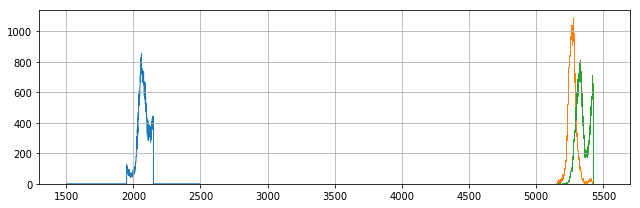

In [8]:
df = inlabframe.loc[{"quantity": "t"}].to_dataframe()
t0 = df["h0C1p"]
t1 = df["h1I1p"]
t2 = df["h2I1p"]

where = slice(None)
# where = cond["labframe"]
# where = cond["flag==14"]

plt.figure(figsize=(9, 3))
plt.hist(t0[where], bins=np.arange(1500, 2500, 1), histtype="step")
plt.hist(t1[where], bins=np.arange(5000, 5500, 1), histtype="step")
plt.hist(t2[where], bins=np.arange(5000, 5500, 1), histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

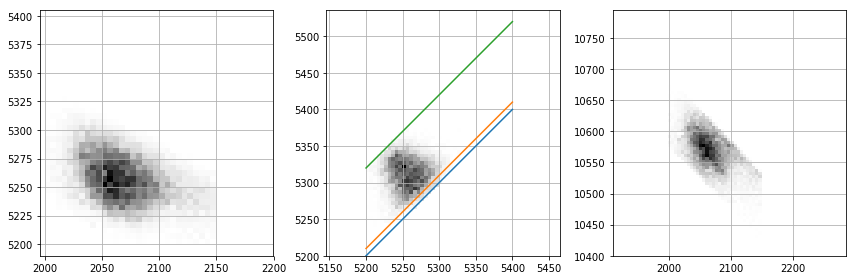

In [21]:
cond["tof"] = (t2 - t1) < 120
where = slice(None)
# where = cond["labframe"]
where = cond["tof"] & cond["labframe"]
# where = (ds["flag"] == 8).to_pandas()
norm = None
# norm = LogNorm()

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist2d(
    t0[where], t1[where],
    bins=(np.arange(2000, 2200, 5),
          np.arange(5200, 5400, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    t1[where], t2[where],
    bins=(np.arange(5200, 5400, 5),
          np.arange(5200, 5500, 5)),
    cmap="Greys",
    norm=norm)
x = np.linspace(5200, 5400)
plt.plot(x, x)
plt.plot(x, x + 10)
plt.plot(x, x + 120)
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist2d(
    t0[where], (t1 + t2)[where],
    bins=(np.arange(2000, 2200, 5),
          np.arange(10400, 10800, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

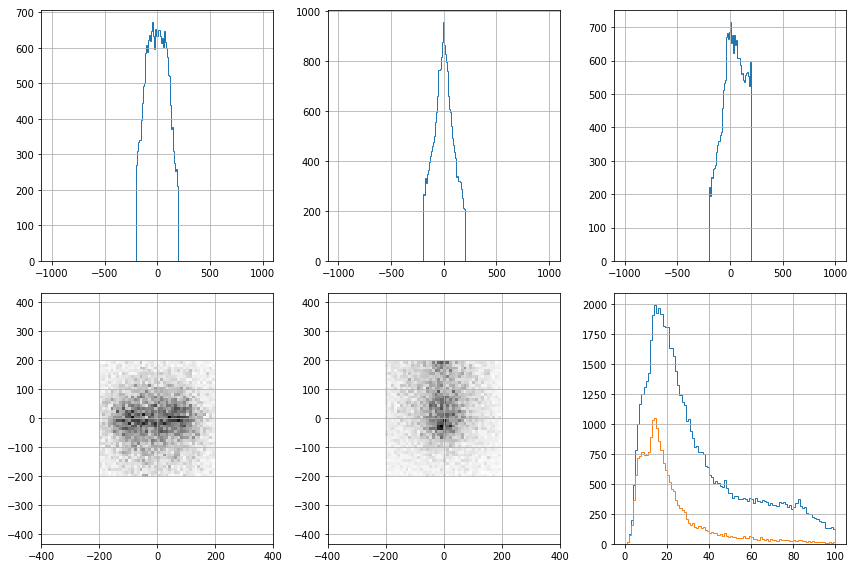

In [12]:
df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())
cond["labframe"] = (
    (-200 < df["px"]) & (df["px"] < 200)
    & (-200 < df["py"]) & (df["py"] < 200)
    & (-200 < df["pz"]) & (df["pz"] < 200)
    )
# where = slice(None)
where = cond["labframe"]
norm = None
# norm = LogNorm()

plt.figure(figsize=[12, 8])
plt.subplot(231)
plt.hist(
    df["px"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(232)
plt.hist(
    df["py"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(233)
plt.hist(
    df["pz"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(234)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(235)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(236)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [15]:
(n,), (m,) = inlabframe["hit"].shape, inlabframe["quantity"].shape
frame = xr.DataArray(
    n * [np.eye(m)],
    dims=["hit", "quantity", "new"],
    coords={"hit": inlabframe["hit"],
            "quantity": inlabframe["quantity"],
            "new": inlabframe["quantity"].values},
    name="frame")

x = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h0C1p"]
y = inlabframe.loc[{"quantity": ["pz", "px", "py"]}]["h1I1p"]
z = xr.apply_ufunc(np.cross, x, y,
                   input_core_dims=[["quantity"], ["quantity"]],
                   output_core_dims=[["quantity"]])
xunit = (x / (x ** 2).sum("quantity") ** 0.5).rename("xunit")
zunit = (z / (z ** 2).sum("quantity") ** 0.5).rename("zunit")
yunit = xr.apply_ufunc(np.cross, zunit, xunit).rename("yunit")

frame.loc[{"quantity": ["pz", "px", "py"], "new": "px"}] = xunit.transpose("hit", "quantity")
frame.loc[{"quantity": ["pz", "px", "py"], "new": "py"}] = yunit.transpose("hit", "quantity")
frame.loc[{"quantity": ["pz", "px", "py"], "new": "pz"}] = zunit.transpose("hit", "quantity")

inmolframe = xr.Dataset({
    k: (inlabframe[k] * frame).sum("quantity")
    for k in ["h0C1p", "h1I1p", "h2I1p"]
}).rename({"new": "quantity"})
inmolframe["summed"] = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]
    .to_array("as_")
    .sum("as_"))
inmolframe

<xarray.Dataset>
Dimensions:   (hit: 68554, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
  * hit       (hit) int64 0 1 2 3 4 5 6 ... 68548 68549 68550 68551 68552 68553
Data variables:
    h0C1p     (hit, quantity) float64 2.141e+03 4.256 ... -1.421e-14 59.01
    h1I1p     (hit, quantity) float64 5.29e+03 -4.672 -2.349 ... 183.9 2.208
    h2I1p     (hit, quantity) float64 5.341e+03 7.192 8.251 ... -172.7 2.121
    summed    (hit, quantity) float64 nan nan nan -40.58 ... 448.0 11.15 63.34

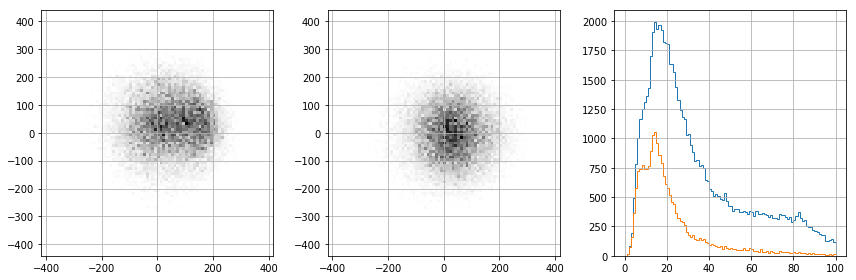

In [22]:
df = (
    inmolframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())

# where = slice(None)
where = cond["labframe"]

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys")
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()